In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from lightgbm import LGBMClassifier
from sklearn.metrics import r2_score,mean_squared_error

In [25]:
df=pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [26]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [27]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [28]:
df.isna().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [29]:
df.duplicated().sum()

np.int64(0)

In [30]:
encoder=LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])

In [31]:
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaled_array = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)

In [32]:
df_scaled.describe()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,3.108624e-17,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-8.864053e-01,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-8.864053e-01,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-8.864053e-01,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,1.128152e+00,7.284319e-01,6.656748e-01,8.851316e-01
max,1.128152e+00,2.235532e+00,2.917671e+00,1.894492e+00


In [33]:
upper_bound = {}
lower_bound = {}

for col in df_scaled.columns:
    q1 = df_scaled[col].quantile(0.25)
    q3 = df_scaled[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound[col] = q3 + 1.5 * iqr
    lower_bound[col] = q1 - 1.5 * iqr

for col in df_scaled.columns:
    df_scaled = df_scaled[(df_scaled[col] >= lower_bound[col]) & (df_scaled[col] <= upper_bound[col])]

In [34]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


In [35]:
pca = PCA(n_components=2, random_state=42)
x = pca.fit_transform(df_scaled)

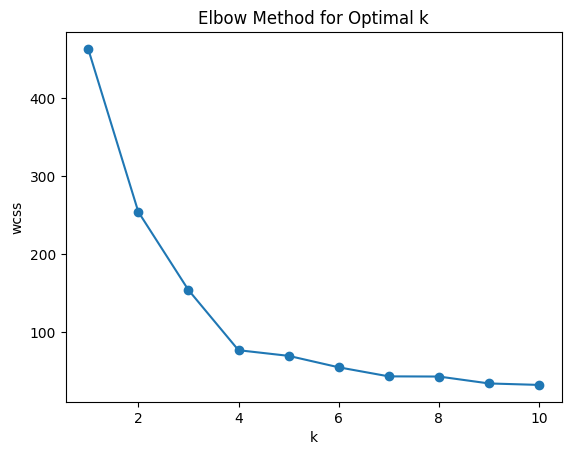

In [36]:
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    WCSS.append(kmeans.inertia_)

plt.plot(range(1,11), WCSS, marker='o')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('Elbow Method for Optimal k')
plt.show()

In [37]:
model = KMeans(n_clusters=4, random_state=42)
labels = model.fit_predict(x)
df_scaled['Cluster'] = labels

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

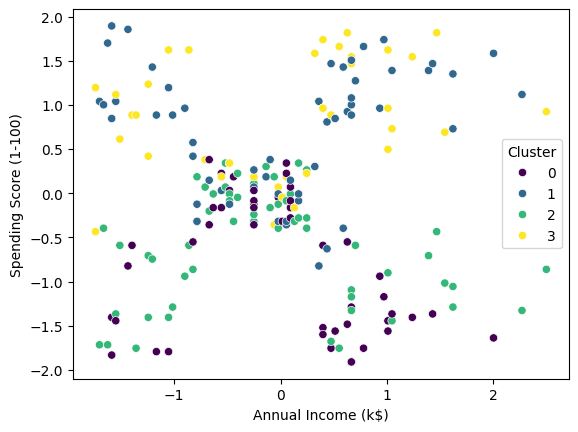

In [38]:
sns.scatterplot(data=df_scaled, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')

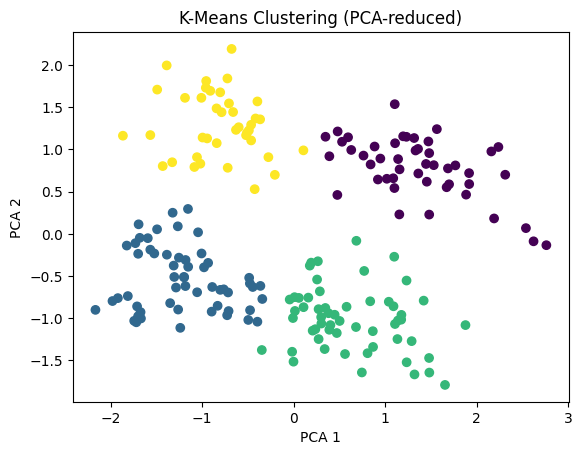

In [39]:
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.show()

In [48]:
score = silhouette_score(x, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.5503428307629536


In [40]:
cluster_stats = df_scaled.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].agg(['mean', 'std', 'min', 'max', 'count'])
print(cluster_stats)


              Age                                     Annual Income (k$)  \
             mean       std       min       max count               mean   
Cluster                                                                    
0        0.786456  1.000450 -1.424569  2.235532    47           0.010298   
1       -0.750475  0.397036 -1.496335  0.082532    56          -0.005017   
2        0.642568  0.718504 -1.352802  2.091999    56          -0.094987   
3       -0.763947  0.506713 -1.496335  0.082532    39          -0.018439   

                                            Spending Score (1-100)            \
              std       min       max count                   mean       std   
Cluster                                                                        
0        0.853209 -1.586321  2.001605    47              -0.805671  0.753248   
1        0.994881 -1.700830  2.268791    56               0.697956  0.718284   
2        0.997779 -1.700830  2.497807    56              -0.594940 

In [41]:
cluster_labels = {
    0: 'Frugal Elders',
    1: 'Impulsive Youth',
    2: 'Conservative Adults',
    3: 'Enthusiastic Shoppers'
}

df_scaled['Cluster'] =df_scaled['Cluster'].map(cluster_labels)

In [42]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1.128152,-1.424569,-1.738999,-0.434801,Enthusiastic Shoppers
1,1.128152,-1.281035,-1.738999,1.195704,Enthusiastic Shoppers
2,-0.886405,-1.352802,-1.700830,-1.715913,Conservative Adults
3,-0.886405,-1.137502,-1.700830,1.040418,Impulsive Youth
4,-0.886405,-0.563369,-1.662660,-0.395980,Conservative Adults


In [49]:
features = df_scaled.drop(['Cluster'], axis=1)
target = df_scaled['Cluster']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])
knn_pipeline.fit(x_train, y_train)
knn_scores = cross_val_score(knn_pipeline, x_train, y_train, cv=5)
print("KNN Test Accuracy:", knn_pipeline.score(x_test, y_test))
print("KNN CV Scores:", knn_scores)
print("KNN CV Best:", np.max(knn_scores))
print("KNN CV Mean:", np.mean(knn_scores))
print("KNN CV Diff:", np.max(knn_scores) - np.mean(knn_scores))

nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])
nb_pipeline.fit(x_train, y_train)
nb_scores = cross_val_score(nb_pipeline, x_train, y_train, cv=5)
print("Naive Bayes Test Accuracy:", nb_pipeline.score(x_test, y_test))
print("Naive Bayes CV Scores:", nb_scores)
print("Naive Bayes CV Best:", np.max(nb_scores))
print("Naive Bayes CV Mean:", np.mean(nb_scores))
print("Naive Bayes CV Diff:", np.max(nb_scores) - np.mean(nb_scores))

dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])
dt_pipeline.fit(x_train, y_train)
dt_scores = cross_val_score(dt_pipeline, x_train, y_train, cv=5)
print("Decision Tree Test Accuracy:", dt_pipeline.score(x_test, y_test))
print("Decision Tree CV Scores:", dt_scores)
print("Decision Tree CV Best:", np.max(dt_scores))
print("Decision Tree CV Mean:", np.mean(dt_scores))
print("Decision Tree CV Diff:", np.max(dt_scores) - np.mean(dt_scores))


KNN Test Accuracy: 1.0
KNN CV Scores: [0.96875    0.96875    0.9375     1.         0.96774194]
KNN CV Best: 1.0
KNN CV Mean: 0.9685483870967742
KNN CV Diff: 0.031451612903225845
Naive Bayes Test Accuracy: 1.0
Naive Bayes CV Scores: [1.      0.9375  0.96875 1.      1.     ]
Naive Bayes CV Best: 1.0
Naive Bayes CV Mean: 0.98125
Naive Bayes CV Diff: 0.018750000000000044
Decision Tree Test Accuracy: 0.95
Decision Tree CV Scores: [1.         0.90625    0.9375     1.         0.96774194]
Decision Tree CV Best: 1.0
Decision Tree CV Mean: 0.9622983870967742
Decision Tree CV Diff: 0.03770161290322582


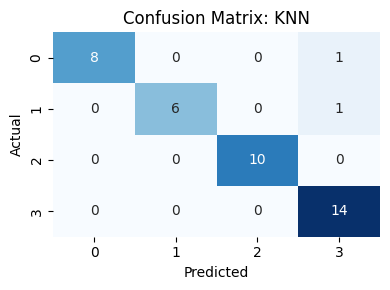

Classification Report: KNN
                       precision    recall  f1-score   support

  Conservative Adults       1.00      0.89      0.94         9
Enthusiastic Shoppers       1.00      0.86      0.92         7
        Frugal Elders       1.00      1.00      1.00        10
      Impulsive Youth       0.88      1.00      0.93        14

             accuracy                           0.95        40
            macro avg       0.97      0.94      0.95        40
         weighted avg       0.96      0.95      0.95        40



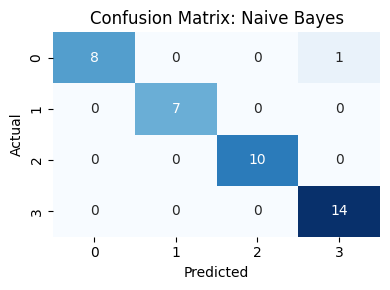

Classification Report: Naive Bayes
                       precision    recall  f1-score   support

  Conservative Adults       1.00      0.89      0.94         9
Enthusiastic Shoppers       1.00      1.00      1.00         7
        Frugal Elders       1.00      1.00      1.00        10
      Impulsive Youth       0.93      1.00      0.97        14

             accuracy                           0.97        40
            macro avg       0.98      0.97      0.98        40
         weighted avg       0.98      0.97      0.97        40



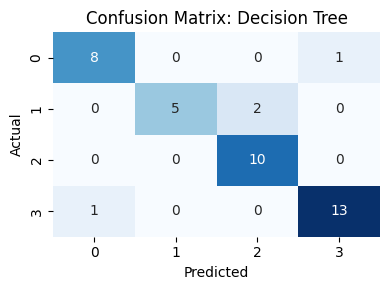

Classification Report: Decision Tree
                       precision    recall  f1-score   support

  Conservative Adults       0.89      0.89      0.89         9
Enthusiastic Shoppers       1.00      0.71      0.83         7
        Frugal Elders       0.83      1.00      0.91        10
      Impulsive Youth       0.93      0.93      0.93        14

             accuracy                           0.90        40
            macro avg       0.91      0.88      0.89        40
         weighted avg       0.91      0.90      0.90        40



In [50]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

y_pred_knn = cross_val_predict(knn_pipeline, x_test, y_test, cv=3)
y_pred_nb = cross_val_predict(nb_pipeline, x_test, y_test, cv=3)
y_pred_dt = cross_val_predict(dt_pipeline, x_test, y_test, cv=3)
y_pred_lr = cross_val_predict(lr_pipeline, x_test, y_test, cv=3)

plot_confusion_matrix(y_test, y_pred_knn, "Confusion Matrix: KNN")
print("Classification Report: KNN")
print(classification_report(y_test, y_pred_knn))

plot_confusion_matrix(y_test, y_pred_nb, "Confusion Matrix: Naive Bayes")
print("Classification Report: Naive Bayes")
print(classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix: Decision Tree")
print("Classification Report: Decision Tree")
print(classification_report(y_test, y_pred_dt))



In [51]:
joblib.dump(knn_pipeline, "knn_model.pkl")
joblib.dump(nb_pipeline, "nb_model.pkl")
joblib.dump(dt_pipeline, "dt_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']